In [1]:
# PDF印刷用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 1
pdf_base = 'pdf-07-'

def create_pdf(plt):
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

def graph_pdf(g):
    global pdf_ind, pdf_base
    fnbase = f'{pdf_base}{pdf_ind:02d}'
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fnbase)
    g.render(fnbase, view=False)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1


# 7章　多値分類

In [2]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [4]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [5]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

## 7.7 NLLLoss損失関数

In [6]:
# 入力変数の準備

# 擬似的な出力データ
outputs_np = np.array(range(1, 13)).reshape((4,3))
# 擬似的な正解データ
labels_np = np.array([0, 1, 2, 0])

# Tensor化
outputs = torch.tensor(outputs_np).float()
labels = torch.tensor(labels_np).long()

# 結果確認
print(outputs.data)
print(labels.data)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([0, 1, 2, 0])


In [7]:
# NLLLoss関数の呼び出し

nllloss = nn.NLLLoss()
loss = nllloss(outputs, labels)
print(loss.item())

-6.25


## 7.8 データ準備

### データ読み込み

In [8]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


### データ絞り込み

In [9]:
# データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


### 訓練データ・検証データの分割

In [10]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


### 訓練データの散布図表示

In [11]:
# データを正解値ごとに分割

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

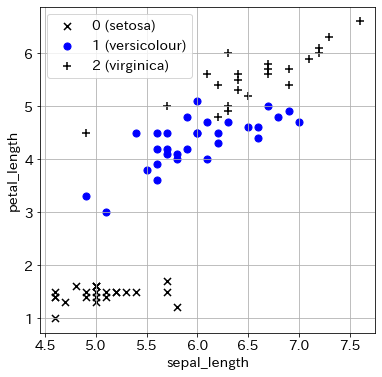

In [12]:
# 散布図の表示

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

## 7.9 モデル定義

In [13]:
# 学習用パラメータ設定

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
# 分類先クラス数　今回は3になる
n_output = len(list(set(y_train)))

# 結果確認
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [14]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1
    
# インスタンスの生成
net = Net(n_input, n_output)        

### モデル確認

In [18]:
# モデル内のパラメータの確認
# l1.weightが行列にl1.biasがベクトルになっている

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [19]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [20]:
# モデルのサマリー表示

summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 最適化アルゴリズムと損失関数

In [21]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

## 7.10 勾配降下法

### データのTensor化

In [22]:
# 入力変数x_trainと正解値 y_trainのテンソル変数化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のテンソル変数化

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

### 計算グラフの視覚化

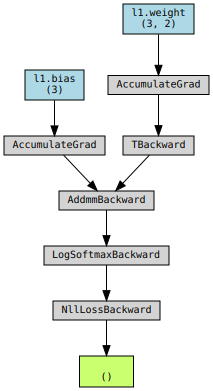

In [23]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失関数の計算グラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [24]:
graph_pdf(g)

pdf-07-01


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 予測ラベル値の取得方法

In [25]:
# torch.max関数呼び出し
# 2つめの引数は軸を意味している。1だと行ごとの集計。
torch.max(outputs, 1)

torch.return_types.max(...)

In [26]:
# ラベル値の配列を取得
torch.max(outputs, 1)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

### 繰り返し計算

In [27]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [28]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 順伝搬計算
    outputs_test = net(inputs_test)

    # 誤差計算
    loss_test = criterion(outputs_test, labels_test)

    #予測値算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 検証データに対する損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ((epoch) % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [10/10000], loss: 1.03580 acc: 0.40000 val_loss: 1.06403, val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347, val_acc: 0.26667
Epoch [30/10000], loss: 0.97672 acc: 0.40000 val_loss: 1.00264, val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351, val_acc: 0.26667
Epoch [50/10000], loss: 0.92616 acc: 0.48000 val_loss: 0.94631, val_acc: 0.38667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098, val_acc: 0.56000
Epoch [70/10000], loss: 0.88212 acc: 0.70667 val_loss: 0.89740, val_acc: 0.60000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545, val_acc: 0.61333
Epoch [90/10000], loss: 0.84373 acc: 0.70667 val_loss: 0.85501, val_acc: 0.62667
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594, val_acc: 0.62667
Epoch [110/10000], loss: 0.81019 acc: 0.72000 val_loss: 0.81815, val_acc: 0.62667
Epoch [120/10000], loss: 0.

## 7.11 結果確認

In [29]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09263 精度: 0.26667
最終状態: 損失関数: 0.19795 精度: 0.96000


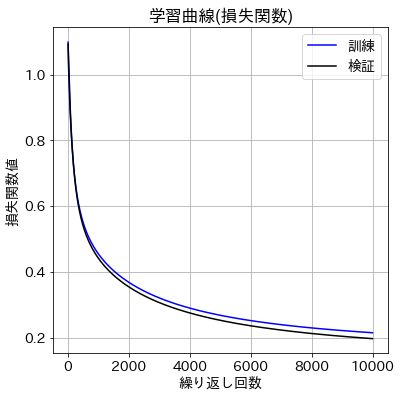

In [30]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

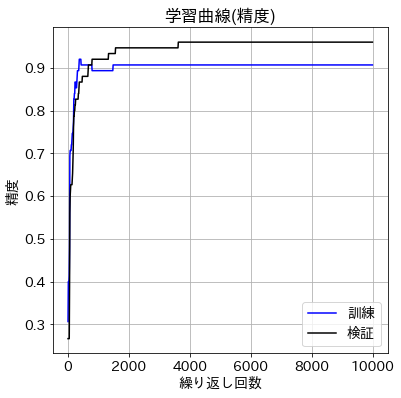

In [31]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### モデルへの入力と出力の確認

In [32]:
# 正解ラベルの0番目、2番目、3番目

print(labels[[0,2,3]])

tensor([1, 0, 2])


In [33]:
# 該当する入力値を抽出

i3 = inputs[[0,2,3],:]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [34]:
# 出力値にsoftmax関数をかけた結果を取得

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[ 8.8071 14.1938 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


### 最終的な重み行列とバイアスの値

In [35]:
# 重み行列
print(net.l1.weight.data)

# バイアス
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


## 7.11 入力変数の4次元化

In [36]:
# 学習データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 入力次元数
n_input = x_train.shape[1]

(75, 4) (75, 4) (75,) (75,)


In [37]:
print('入力データ(x)')
print(x_train[:5,:])
print(f'入力次元数: {n_input}')

入力データ(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
入力次元数: 4


In [38]:
# 入力変数x_trainと正解値 y_trainのTesor化
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のTensor化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [39]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [40]:
for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 順伝搬計算
    outputs_test = net(inputs_test)

    # 誤差計算
    loss_test = criterion(outputs_test, labels_test)

    #予測値算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 検証データに対する損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [41]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09158 精度: 0.26667
最終状態: 損失関数: 0.13724 精度: 0.96000


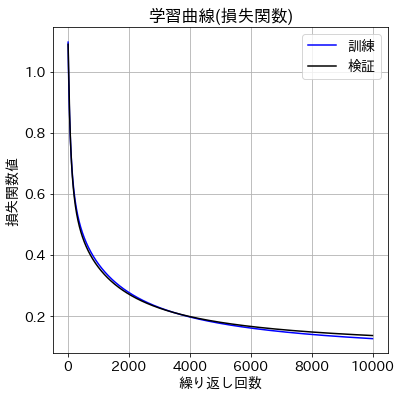

In [42]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

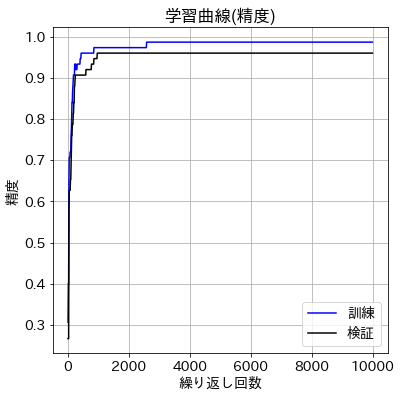

In [43]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

## コラム softmax 関数と交差エントロピー関数の微妙な関係

### パターン1 モデルクラス側にlogsoftmax関数を含める

In [44]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # softmax関数の定義
        self.softmax = nn.LogSoftmax(dim=1)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [45]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： NLLLoss
criterion = nn.NLLLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [46]:
for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 順伝搬計算
    outputs_test = net(inputs_test)

    # 誤差計算
    loss_test = criterion(outputs_test, labels_test)

    #予測値算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 検証データに対する損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [47]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09158 精度: 0.26667
最終状態: 損失関数: 0.13724 精度: 0.96000


In [48]:
# パターン1モデルの出力結果
w = outputs[:5,:].data
print(w.numpy())

# 確率値を得たい場合
print(torch.exp(w).numpy())

[[ -5.1283  -0.0992  -2.4251]
 [ -4.9799  -0.021   -4.274 ]
 [ -0.0563  -2.9047 -16.2378]
 [-11.7813  -3.2099  -0.0412]
 [ -9.2329  -1.747   -0.1916]]
[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]


### パターン2 モデルクラス側は素のsoftmax

In [49]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # softmax関数の定義
        self.softmax = nn.Softmax(dim=1)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [50]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： NLLLoss
criterion = nn.NLLLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [51]:
for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)
    
    # ここで対数関数にかける
    outputs2 = torch.log(outputs)

    # 誤差計算
    loss = criterion(outputs2, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 順伝搬計算
    outputs_test = net(inputs_test)
        
    # ここで対数関数にかける
    outputs2_test = torch.log(outputs_test)

    # 誤差計算
    loss_test = criterion(outputs2_test, labels_test)

    #予測値算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 検証データに対する損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [52]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09158 精度: 0.26667
最終状態: 損失関数: 0.13724 精度: 0.96000


In [53]:
w = outputs[:5,:].data.numpy()
print(w)

[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]
